# Level 4: Advanced Modeling #

In the last section we used Linear Models and K-Nearest Neighbors to predict the amount of rainfall, so now let's spice things up a bit with more advanced modeling techniques. In this level we'll explore ways to transform our data, as well as some machine learning tools that can help our predictive performance. 

First we start by loading our data from the csv file into a pandas dataframe.

In [1]:
import pandas as pd

df = pd.read_csv("clean_weather_data.csv")
df.head()

,Month,Day,Year,Mean Temperature,Max Temperature,Min Temperature,Dew Point,Average Humidity,Maximum Humidity,Minimum Humidity,Precipitation,Wind Speed,Max Wind Speed,Max Gust Speed
0,1,1,2013,33,40,26,22,54,64,44,0,7,15,26
1,1,2,2013,28,33,22,11,48,57,39,0,6,15,22
2,1,3,2013,28,32,24,14,56,68,43,0,5,13,20
3,1,4,2013,34,37,30,19,56,63,48,0,8,18,28
4,1,5,2013,37,42,32,19,48,56,39,0,7,17,26


To predict whether or not it'll rain on a given day, let's come up with an easy way to denote "rain" or "no rain." Since we're lazy and don't want to write real words when we don't have to, we can turn our Precipitation level data into 0's for days without rain and 1's for days with rain. This is accomplished with the following code:

In [2]:
import numpy as np

y = np.array(df["Precipitation"] != 0, dtype=int)
data = df.drop('Precipitation',axis=1)

Wait...so far, we haven't been using day or month data. We could potentially be missing out on some powerful features: maybe there's truth to "April showers bring May flowers." The problem is that month and day are categorical variables, so we can't just use the current encoding. What we have to do is add a new dimension for each possible day and month and zero out all dimensions except for the ones corrsponding to the appropriate month and day. 

So for example, on January 1st, both the January column and the 1st day of the month column will be set to 1. This is called one of k encoding or one hot encoding. We can use sklearn to easily transform our data. First we isolate the Day and Month columns and do one hot encoding using the OneHotEncoder class in the preprocessing module of sklearn.

In [3]:
from sklearn.preprocessing import OneHotEncoder

one_hot = OneHotEncoder()
new_day = one_hot.fit_transform(data[["Month","Day"]]).toarray()

Here, ```fit_transform``` does all the work of figuring out what the possible categories are and assigning dimensions to them. Let's take a look to see what's happening. If we look at the first row of the resulting array we should see a 1 in the January column and a 1 on the first day of the month column.

In [4]:
new_day[0, :]

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.])

Now we can combine the one hot encoded features with our original data and split into train and test data.

In [5]:
X = np.hstack([new_day, data.values[:, 2:]])

In [6]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Now onto some machine learning techniques. A popular classification algorithm is the Support Vector Machine or SVM. Basically what the SVM does is described in the below image.

<img src=diagram_svm_maximal_margin.gif >
Source: http://www.improvedoutcomes.com/docs/WebSiteDocs/Introduction/Tutorials/Tutorial_9_Support_Vector_Machines/Tutorial_9__Introduction.htm

The goal of the SVM is to make a line which separates the two classes (red and green) as best as possible. The intuition is that the "best" way to separate the classes is to make a line which is as close to being in between both classes as possible. 

In the above image, panels A, B, and C aren't such good separating lines because they just barely don't touch a member of one of the classes. These kinds of boundaries feel unwieldy, and probably wouldn't work well if we added more data into the mix. Panel D shows the "maximum margin" solution of the SVM, which makes a line which is equidistant from each class -- there's a lot of wiggle room. The SVM generalizes to any number of dimensions, so we can use it with our data to predict whether it will rain on a particular day. For this we use sklearn's SVC class. Sklearn is designed to work fairly simply, so all we have to do is call the ```fit()``` and ```predict()``` methods of the SVC class and we have a working SVM! Let's fit an SVM on our training set and test it on our test data.

In [7]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, y_train)
svm.score(X_test, y_test)

0.85643564356435642

That's not bad accuracy given that we're predicting the weather, but maybe we can do better! When the SVM is finding the maximum margin line, it allows itself to make errors and misclassify training data. This is because we want the boundary to be generalizable to other datasets, not just the one we currently have. We, as the data scientists, assign a cost to these misclassifications, and the cost is called a hyperparameter. 

But what cost parameter do we choose? We can't just pick *any* number -- we want the *best possible* cost parameter that will make our model as smart as it can be. We also want the optimal cost obtained from several different training sets so that our model will be prepared for any type of data we throw at it later. Recall our previous train-test split, where we hid away a portion of the data and trained the model on the remaining set. We could try that again here, but our model might get too comfortable with that one test set and figure out a clever cost parameter that works really well for that specific dataset only. We need to make sure it doesn't get lazy and train it as hard as possible. So what should we do?

Let's try breaking up our training data into K sections called "folds." At each iteration we hide one fold and train the SVM on the remaining K-1 folds, trying out several possible costs for the SVM. For each cost we quantify the model's performance by taking the average test error over all folds, then pick the cost parameter with the lowest overall test error. This is called K-Fold Cross Validation. Since pictures always make more sense than words, an example (for K = 7) is shown below.

![K-Folds Picture](kfolds.png)
Source: https://powerofmlexperience.wordpress.com/2015/07/15/k-fold-cross-validation-made-simple/

Say we are trying to approximate the test error for a cost of 1, using 7-fold cross validation. We would go through each array in the above image, train on the green portion and obtain the error on the gray portion. The averaged errors over the seven folds is the performance of setting the model's cost equal to 1. It's a bit complex, but thankfully sklearn takes care of almost everything for us with its ```grid_search``` module. We can use it (and plot the errors for different costs) as follows: we define the parameters that we want to sweep through (in this case cost) and then we get all of the errors.

In [8]:
from sklearn.grid_search import GridSearchCV

parameters = {"kernel": ["linear"], 
              'C': [10 ** i for i in range(-5, 2)]}
search = GridSearchCV(SVC(), param_grid=parameters, refit=True, cv=5)
search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ['linear'], 'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


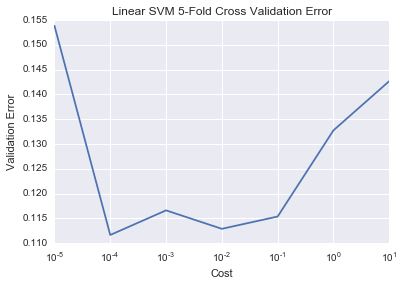

In [9]:
#plot the validation error

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

errs = [1 - score[1] for score in search.grid_scores_]
cs = parameters["C"]
plt.plot(cs,errs)
plt.semilogx()
plt.xlabel("Cost")
plt.ylabel("Validation Error")
plt.title("Linear SVM 5-Fold Cross Validation Error")

We can check what the best parameters are like this.

In [10]:
search.best_params_

{'C': 0.0001, 'kernel': 'linear'}

The cool thing about sklearn is that the ```GridSearchCV``` class keeps the best SVM that it found, and then we can use it simply by using ```predict()``` and ```score()``` like before.

In [11]:
search.score(X_test, y_test)

0.86633663366336633

That's even better accuracy, but what if a straight line isn't even a good way to divide the two classes? What if the line is curved or wiggly? We can add this "wigglyness" to the SVM by using kernels. Basically a kernel maps our data to a higher dimension, and then the SVM finds a linear separation of the data in that higher dimension. When the data is mapped back to our (lower) dimension, the SVM's line in the higher dimension turns out to be curved. Don't believe me? Take a look at the video below to see an illustrative example. 


[![SVM Kernel Video](http://img.youtube.com/vi/3liCbRZPrZA/0.jpg)](http://www.youtube.com/watch?v=3liCbRZPrZA)

For this tutorial we'll be using the Radial Basis Function or RBF kernel. It's a little bit different than the kernel above because it maps to infinite dimensions, but that's for another time. 

When training an RBF kernel SVM, there are two hyperparameters: one is the cost, which we've dealt with before, and the other is "gamma." Gamma controls how wiggly the line can be. But this isn't a problem -- we can just use K-Fold Cross Validation as last time, and consider pairs of costs and gammas. The code to do this is almost exactly the same as before, since we just add another parameter to sweep over.

In [12]:
params = {"kernel":["rbf"], 
          "C":[10**i for i in np.arange(-1, 3, .5)],
          "gamma":[10**i for i in np.arange(-10, 0)]}
              
search = GridSearchCV(SVC(), param_grid=params, refit=True, cv=5)
search.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ['rbf'], 'C': [0.10000000000000001, 0.31622776601683794, 1.0, 3.1622776601683795, 10.0, 31.622776601683793, 100.0, 316.22776601683796], 'gamma': [1e-10, 1.0000000000000001e-09, 1e-08, 9.9999999999999995e-08, 9.9999999999999995e-07, 1.0000000000000001e-05, 0.0001, 0.001, 0.01, 0.10000000000000001]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

([<matplotlib.axis.YTick at 0x10e630048>,
 <a list of 8 Text yticklabel objects>)

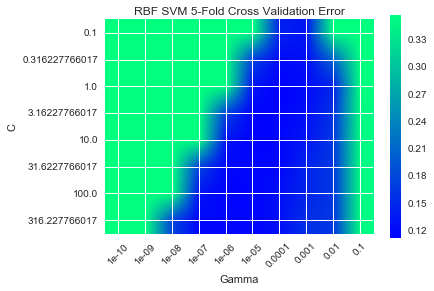

In [13]:
#plot errors
errs = [1 - score[1] for score in search.grid_scores_]

errs = np.array(errs).reshape(len(params["C"]), len(params["gamma"]))
plt.imshow(errs,cmap="winter")
plt.xlabel('Gamma')
plt.ylabel('C')
plt.title("RBF SVM 5-Fold Cross Validation Error")
plt.colorbar()
plt.xticks(np.arange(len(params["gamma"])), params["gamma"], rotation=45)
plt.yticks(np.arange(len(params["C"])),params["C"])

Again we can check what the best parameters were, and see how our performance on the test set is:

In [14]:
print(search.best_params_)
print(search.score(X_test, y_test))

{'C': 1.0, 'gamma': 0.0001, 'kernel': 'rbf'}
0.856435643564


We get a similar performance with the normal (linear) SVM and the RBF SVM, but that won't always be the case. Now you can go explore other kernels and try them out!